<a href="https://colab.research.google.com/github/fymatsushita/pediatrics/blob/main/PredictiveModel_24h_Mortality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lux

In [ ]:
df.head()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [ ]:
df['Alert'] = df['Alert'].astype(float)
df.info()

<class 'lux.core.frame.LuxDataFrame'>
RangeIndex: 1931 entries, 0 to 1930
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Lactate     1931 non-null   float64
 1   pH          1931 non-null   float64
 2   pCO2        1931 non-null   float64
 3   BIC         1931 non-null   float64
 4   BE          1931 non-null   float64
 5   Lactate_pH  1931 non-null   float64
 6   DOL         1931 non-null   int64  
 7   cGA         1931 non-null   float64
 8   Alert       1931 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 135.9 KB


In [ ]:
df.describe().T

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

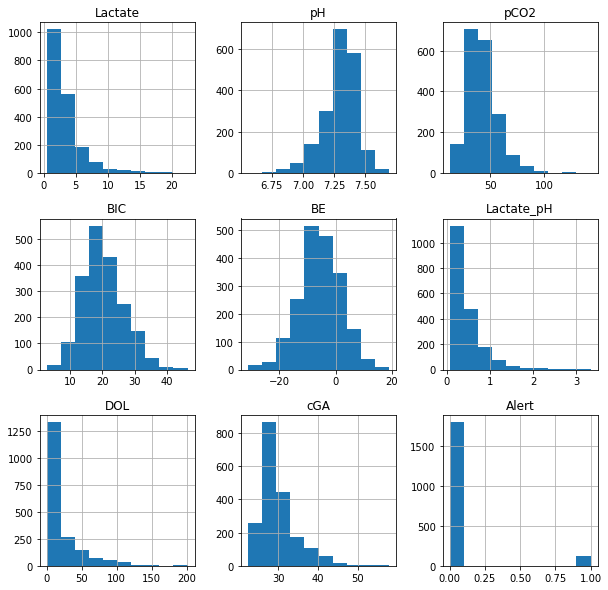

In [ ]:
p = df.hist(figsize=(10,10))

In [ ]:
df.shape

(1931, 9)

In [ ]:
print(df.isnull().sum())

Lactate       0
pH            0
pCO2          0
BIC           0
BE            0
Lactate_pH    0
DOL           0
cGA           0
Alert         0
dtype: int64


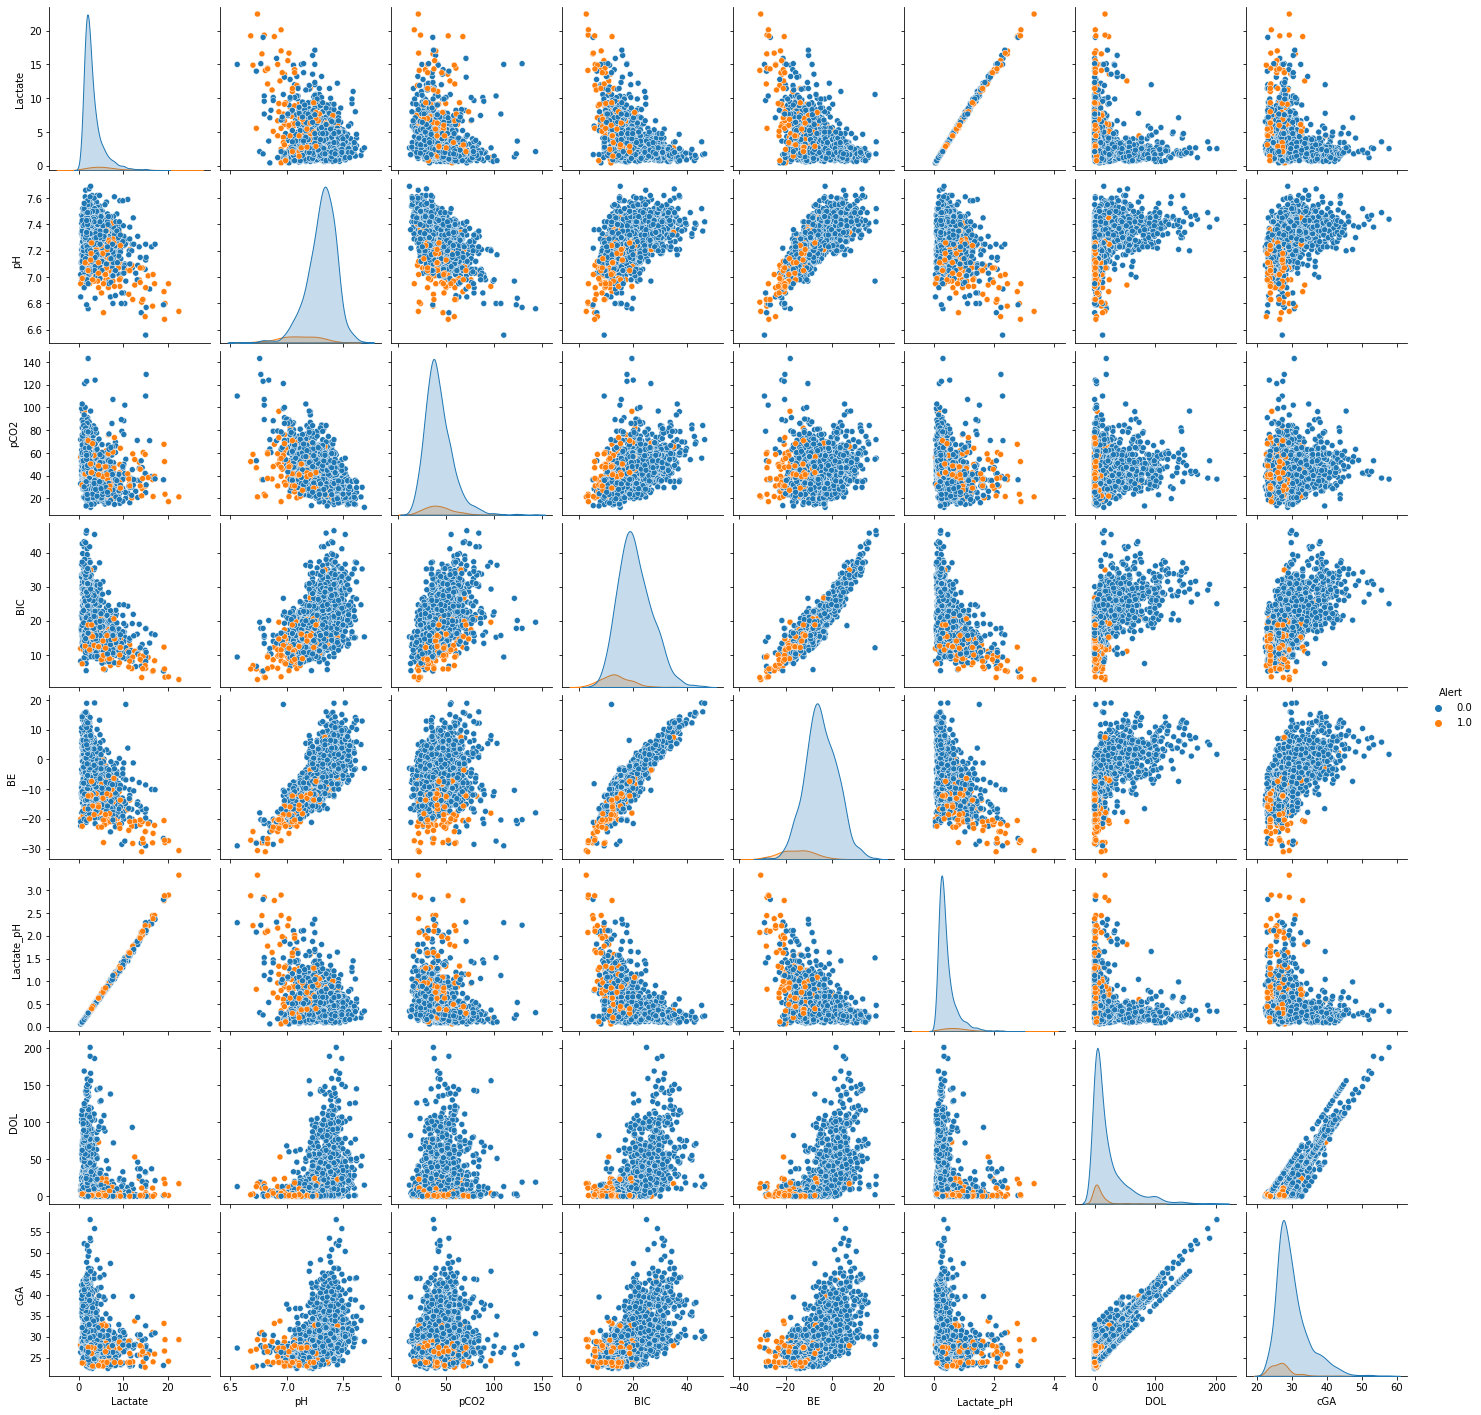

In [ ]:
l = sns.pairplot(df, hue='Alert')

In [ ]:
X_train = df.loc[:,df.columns != 'Alert']
y_train = df['Alert']

In [ ]:
from BorutaShap import BorutaShap

feature_selector = BorutaShap(importance_measure='shap', classification=False)
feature_selector.fit(X=X_train, y=y_train, n_trials=50, random_state=0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


  0%|          | 0/50 [00:00<?, ?it/s]

3 attributes confirmed important: ['BE', 'Lactate_pH', 'cGA']
5 attributes confirmed unimportant: ['Lactate', 'BIC', 'pH', 'pCO2', 'DOL']
0 tentative attributes remains: []


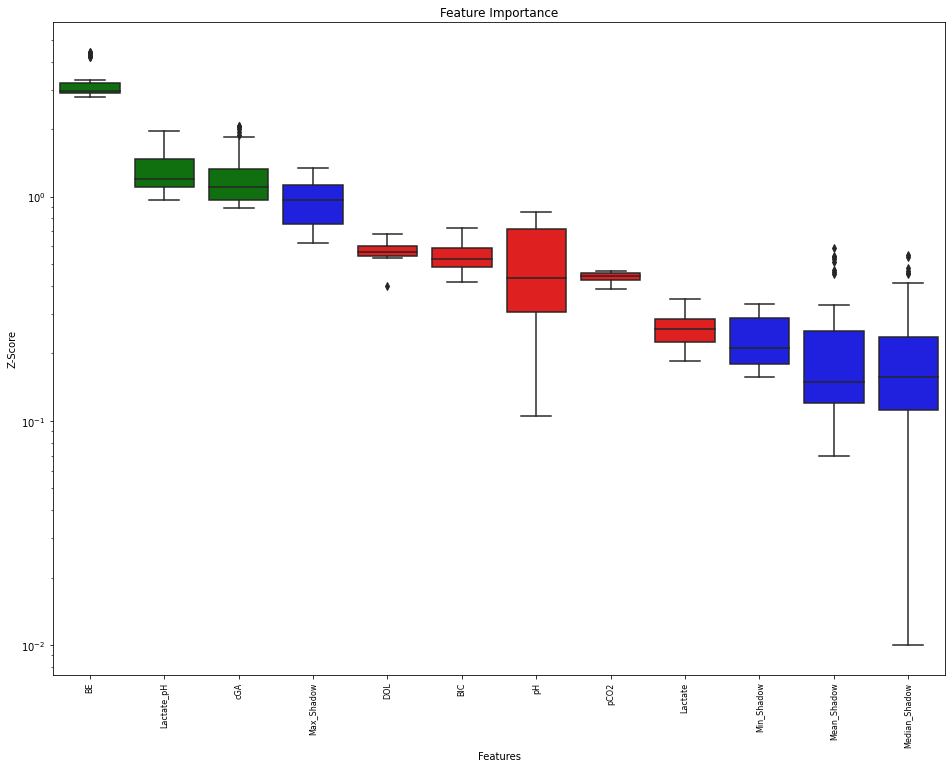

In [ ]:
feature_selector.plot(which_features='all', figsize=(16,12))

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import train_test_split
X = df.loc[:,df.columns != 'Alert']
y = df['Alert']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3)


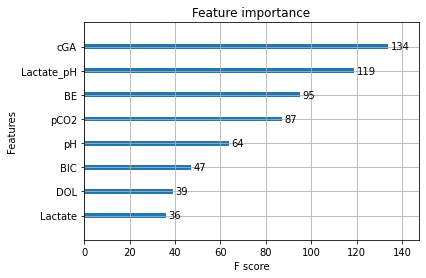

In [ ]:
model_xgb = XGBClassifier()
model_xgb.fit(train_X, train_y, verbose=False)
xgb.plot_importance(model_xgb, max_num_features=10)
plt.show()

In [ ]:
pred_xgb = model_xgb.predict(test_X)

In [ ]:
# Grid search
def GridSearchModel(X, y, model, parameters, cv):
  CV_model = GridSearchCV(estimator=model, param_grid = parameters, cv = cv)
  CV_model.fit(X,y)
  CV_model.cv_results_
  print("Best Score:", CV_model.best_score_, " / Best parameters:", CV_model.best_params_)

In [ ]:
# Learning curve
def LearningCurve(X, y, model, cv, train_sizes):

    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv = cv, n_jobs = 4, 
                                                            train_sizes = train_sizes)

    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std  = np.std(train_scores, axis = 1)
    test_scores_mean  = np.mean(test_scores, axis = 1)
    test_scores_std   = np.std(test_scores, axis = 1)
    
    train_Error_mean = np.mean(1- train_scores, axis = 1)
    train_Error_std  = np.std(1 - train_scores, axis = 1)
    test_Error_mean  = np.mean(1 - test_scores, axis = 1)
    test_Error_std   = np.std(1 - test_scores, axis = 1)

    Scores_mean = np.mean(train_scores_mean)
    Scores_std = np.mean(train_scores_std)
    
    _, y_pred, Accuracy, Error, precision, recall, f1score = ApplyModel(X, y, model)
    
    plt.figure(figsize = (16,4))
    plt.subplot(1,2,1)
    ax1 = Confuse(y, y_pred, classes)
    plt.subplot(1,2,2)
    plt.fill_between(train_sizes, train_Error_mean - train_Error_std,train_Error_mean + train_Error_std, alpha = 0.1,
                     color = "r")
    plt.fill_between(train_sizes, test_Error_mean - test_Error_std, test_Error_mean + test_Error_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_Error_mean, 'o-', color = "r",label = "Training Error")
    plt.plot(train_sizes, test_Error_mean, 'o-', color = "g",label = "Cross-validation Error")
    plt.legend(loc = "best")
    plt.grid(True)
     
    return (model, Scores_mean, Scores_std )

In [ ]:
def ApplyModel(X, y, model):
    
    model.fit(X, y)
    y_pred  = model.predict(X)

    Accuracy = round(np.median(cross_val_score(model, X, y, cv = cv)),2)*100
 
    Error   = 1 - Accuracy
    
    precision = precision_score(y_train, y_pred) * 100
    recall = recall_score(y_train, y_pred) * 100
    f1score = f1_score(y_train, y_pred) * 100
    
    return (model, y_pred, Accuracy, Error, precision, recall, f1score) 

In [ ]:
def Confuse(y, y_pred, classes):
    cnf_matrix = confusion_matrix(y, y_pred)
    
    cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis = 1)[:, np.newaxis]
    c_train = pd.DataFrame(cnf_matrix, index = classes, columns = classes)  

    ax = sns.heatmap(c_train, annot = True, cmap = cmap, square = True, cbar = False, 
                          fmt = '.2f', annot_kws = {"size": 20})
    return(ax, c_train)

In [ ]:
def PrintResults(model, X, y, title):
    
    model, y_pred, Accuracy, Error, precision, recall, f1score = ApplyModel(X, y, model)
    
    _, Score_mean, Score_std = LearningCurve(X, y, model, cv, train_size)
    Score_mean, Score_std = Score_mean*100, Score_std*100
    
    
    print('Scoring Accuracy: %.2f %%'%(Accuracy))
    print('Scoring Mean: %.2f %%'%(Score_mean))
    print('Scoring Standard Deviation: %.4f %%'%(Score_std))
    print("Precision: %.2f %%"%(precision))
    print("Recall: %.2f %%"%(recall))
    print('f1-score: %.2f %%'%(f1score))
    
    Summary = pd.DataFrame({'Model': title,
                       'Accuracy': Accuracy, 
                       'Score Mean': Score_mean, 
                       'Score St Dv': Score_std, 
                       'Precision': precision, 
                       'Recall': recall, 
                       'F1-Score': f1score}, index = [0])
    return (model, Summary)

In [ ]:
from sklearn.model_selection import ShuffleSplit
classes = ['0','1']
cv = ShuffleSplit(n_splits = 100, test_size = 0.3, random_state = 0)
train_size = np.linspace(.1, 1.0, 15)

In [ ]:
from sklearn.model_selection import train_test_split 
X = df.drop(['pCO2', 'pH', 'BIC', 'DOL','Alert', 'Lactate','BE','cGA'], 1)
X2 = df.drop(['Alert'], 1)
y = df['Alert']

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3, random_state=40, stratify=y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

Scoring Accuracy: 94.00 %
Scoring Mean: 94.49 %
Scoring Standard Deviation: 1.0127 %
Precision: 68.42 %
Recall: 28.89 %
f1-score: 40.62 %


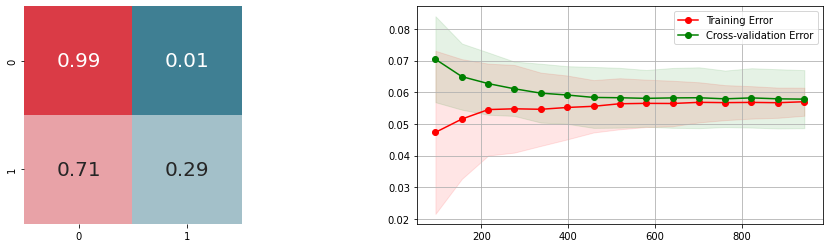

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
cmap = sns.diverging_palette(220,10, as_cmap=True)
model = LogisticRegression()
model, Summary_LR = PrintResults(model, X_train, y_train, 'Logistic Regression')

y_train_LR = pd.Series(model.predict(X_train), name = "LR")
y_test_LR = pd.Series(model.predict(X_test), name = "LR")

Scoring Accuracy: 95.00 %
Scoring Mean: 100.00 %
Scoring Standard Deviation: 0.0010 %
Precision: 100.00 %
Recall: 100.00 %
f1-score: 100.00 %


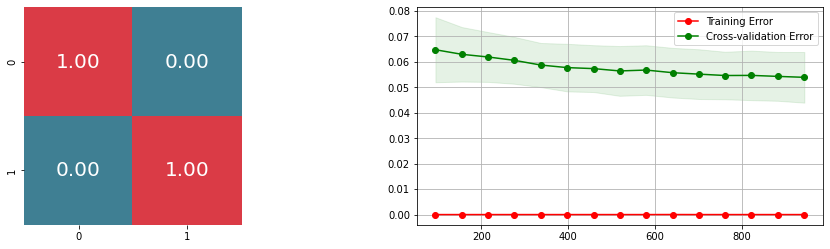

In [ ]:
from sklearn.ensemble import RandomForestClassifier
%timeit
model = RandomForestClassifier(n_estimators = 200)
model,Summary_RF = PrintResults(model, X_train, y_train, 'Random Forest')
y_train_RF = pd.Series(model.predict(X_train), name="RF")
y_test_RF = pd.Series(model.predict(X_test), name = "RF")

In [ ]:
model, y_pred, Accuracy, Error, precision, recall, f1score = ApplyModel(X_train, y_train, model)
Priority = pd.DataFrame({'Feature': X_train.columns, 'Importance':np.round(model.feature_importances_,3)})
Priority = Priority.sort_values('Importance',ascending=False).set_index('Feature')
print(Priority)

            Importance
Feature               
BE               0.177
pH               0.153
Lactate_pH       0.147
BIC              0.130
pCO2             0.125
cGA              0.107
Lactate          0.090
DOL              0.071


Scoring Accuracy: 94.00 %
Scoring Mean: 94.79 %
Scoring Standard Deviation: 0.9606 %
Precision: 84.00 %
Recall: 23.33 %
f1-score: 36.52 %


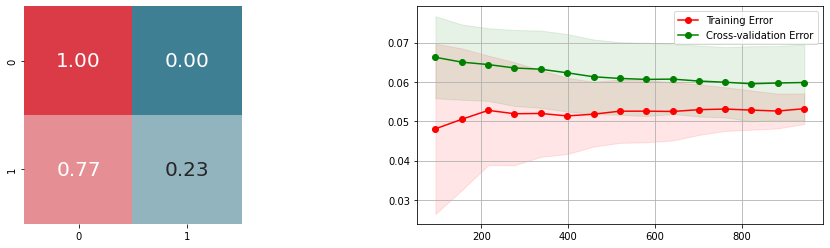

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split (X_scaled, y, test_size=0.3, random_state=40, stratify=y)

model = SVC()
model, Summary_SVM = PrintResults(model, X_train_scaled, y_train_scaled, 'SVM')
y_train_SVM = pd.Series(model.predict(X_train_scaled), name = "SVM")
y_test_SVM = pd.Series(model.predict(X_test_scaled), name = 'SVM')

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:Liblinear failed to converge, increase the number of iterations.
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:Liblinear failed to converge, increase the number of iterations.
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:Liblinear failed to converge, increase the number of iterations.
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:Liblinear failed to converge, increase the number of iterations.
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:Liblinear failed to converge, increase the number of iterations.
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:Liblinear failed to converge, increase the number of iterations.
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:Liblinear failed to co

Scoring Accuracy: 95.00 %
Scoring Mean: 94.70 %
Scoring Standard Deviation: 0.9616 %
Precision: 85.71 %
Recall: 26.67 %
f1-score: 40.68 %


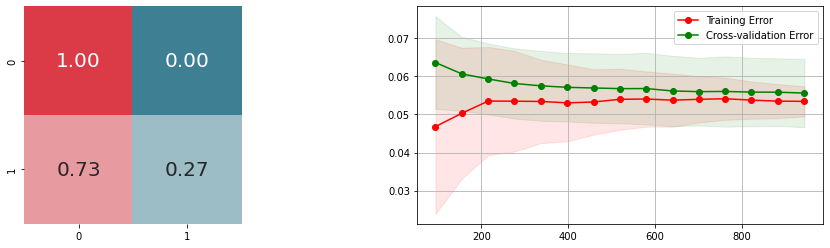

In [ ]:
from sklearn.svm import LinearSVC
model = LinearSVC()
model,Summary_LSVM = PrintResults(model, X_train_scaled, y_train,"LSVM")
y_train_LSVM = pd.Series(model.predict(X_train_scaled), name = "LSVM")
y_test_LSVM = pd.Series(model.predict(X_test_scaled), name = "LSVM")

Scoring Accuracy: 94.00 %
Scoring Mean: 93.63 %
Scoring Standard Deviation: 1.7315 %
Precision: 65.85 %
Recall: 30.00 %
f1-score: 41.22 %


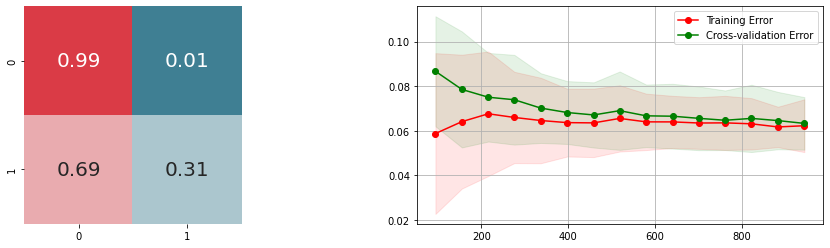

In [ ]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(max_iter = 200, tol = None)
model, Summary_SGD = PrintResults(model, X_train_scaled, y_train, 'SGD')
y_train_SGD = pd.Series(model.predict(X_train_scaled), name = "SGD")
y_test_SGD = pd.Series(model.predict(X_test_scaled), name= 'SGD')

Scoring Accuracy: 94.00 %
Scoring Mean: 95.35 %
Scoring Standard Deviation: 0.8926 %
Precision: 81.40 %
Recall: 38.89 %
f1-score: 52.63 %


0.6461443670316128

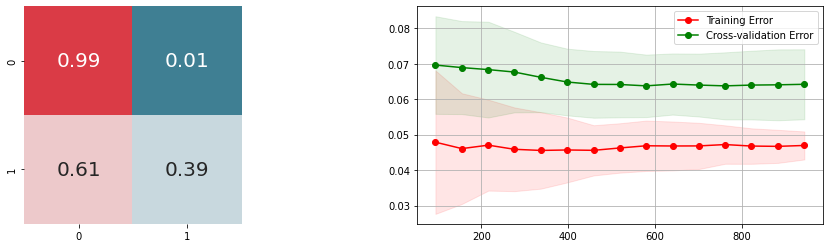

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors = 3)
model, Summary_KNN = PrintResults(model, X_train_scaled, y_train, 'KNN')
y_train_KNN = pd.Series(model.predict(X_train_scaled), name = "KNN")
y_test_KNN = pd.Series(model.predict(X_test_scaled), name="KNN")

Scoring Accuracy: 89.00 %
Scoring Mean: 89.31 %
Scoring Standard Deviation: 1.8510 %
Precision: 33.55 %
Recall: 56.67 %
f1-score: 42.15 %


0.8470069671548415

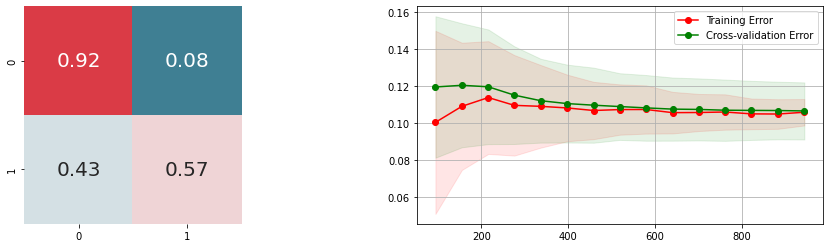

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model,Summary_GNB = PrintResults(model, X_train, y_train, "GNB")
y_train_GNB = pd.Series(model.predict(X_train), name = "GNB")
y_test_GNB = pd.Series(model.predict(X_test), name = "GNB")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:Maximum number of iteration reached befo

Scoring Accuracy: 91.00 %
Scoring Mean: 91.00 %
Scoring Standard Deviation: 4.1610 %
Precision: 39.68 %
Recall: 27.78 %
f1-score: 32.68 %


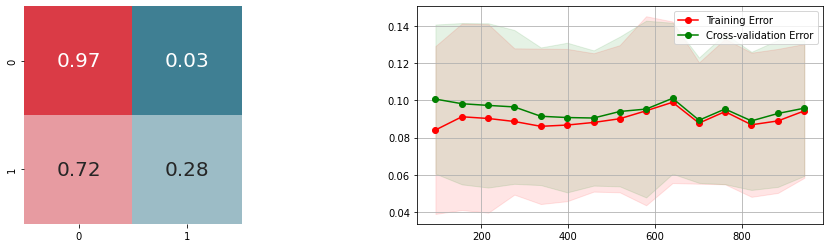

In [ ]:
from sklearn.linear_model import Perceptron
model = Perceptron(max_iter = 5)
model,Summary_MLP = PrintResults(model, X_train_scaled, y_train, 'MLP')
y_train_MLP = pd.Series(model.predict(X_train_scaled), name = "MLP")
y_test_MLP = pd.Series(model.predict(X_test_scaled), name = "MLP")

Scoring Accuracy: 95.00 %
Scoring Mean: 99.67 %
Scoring Standard Deviation: 0.2546 %
Precision: 100.00 %
Recall: 86.67 %
f1-score: 92.86 %


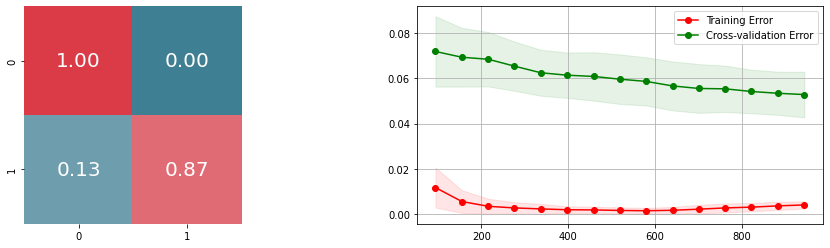

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(objective="binary:logistic", eta=0.01, max_depth=6, min_child_weight=1, 
                      scale_pos_weight=1, gamma=0, colsample_bytree=0.9, nthread=4,
                      early_stopping_round=5)
model,Summary_XGB = PrintResults(model, X_train, y_train, 'XGB')
y_train_XGB = pd.Series(model.predict(X_train), name = "XGB")
y_test_XGB = pd.Series(model.predict(X_test), name = "XGB")

In [ ]:
Class_Results = pd.concat([Summary_LR, Summary_SGD, Summary_RF, 
                           Summary_SVM, Summary_KNN, Summary_GNB,
                           Summary_MLP, Summary_LSVM, Summary_XGB], ignore_index = True)
    

Class_Results = Class_Results.sort_values(by = 'F1-Score', ascending=False)
Class_Results = Class_Results.set_index('F1-Score')
print(Class_Results)

                          Model  Accuracy  ...   Precision      Recall
F1-Score                                   ...                        
100.000000        Random Forest      95.0  ...  100.000000  100.000000
92.857143                   XGB      95.0  ...  100.000000   86.666667
52.631579                   KNN      94.0  ...   81.395349   38.888889
42.148760                   GNB      89.0  ...   33.552632   56.666667
41.221374                   SGD      94.0  ...   65.853659   30.000000
40.677966                  LSVM      95.0  ...   85.714286   26.666667
40.625000   Logistic Regression      94.0  ...   68.421053   28.888889
36.521739                   SVM      94.0  ...   84.000000   23.333333
32.679739                   MLP      91.0  ...   39.682540   27.777778

[9 rows x 6 columns]


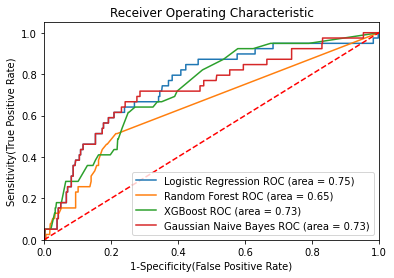

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(),
},
{
    'label': 'XGBoost',
    'model': XGBClassifier()
},
{
    'label': 'Gaussian Naive Bayes',
    'model': GaussianNB()
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
    y_pred=model.predict(X_test) # predict the test data

# Compute False postive rate, and True positive rate
    pred = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,pred)
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display